In [1]:
import numpy as np
from numpy import cos, sin, tan, arccos, arcsin, arctan, arctan2, pi, exp, sqrt, cosh, fabs, deg2rad, rad2deg
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import datetime
import math

<h3>example image</h3>

<h3>coordinates</h3>

In [2]:
# coordinates:
pixelsize = 3.

# definition of image space
l_min,l_max = -180,180
b_min,b_max = -90,90
#deg2rad = pi/180

# definition of pixel size and number of bins
n_l = int((l_max-l_min)/pixelsize)
n_b = int((b_max-b_min)/pixelsize)

b_arrg = np.linspace(b_min,b_max,n_b+1)*deg2rad(1)
l_arrg = np.linspace(l_min,l_max,n_l+1)*deg2rad(1)
b_arr = (b_arrg[1:]+b_arrg[0:-1])/2
l_arr = (l_arrg[1:]+l_arrg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

# jacobian (integral measure on a sphere, exact for this pixel definition, should be 4pi for full sky)
dOmega = (np.sin(B_ARR + deg2rad(pixelsize/2)) - np.sin(B_ARR - deg2rad(pixelsize/2))) * pixelsize * deg2rad(1)
print(np.sum(dOmega))
print(4*pi)

12.566370614359176
12.566370614359172


<h3>2D Gaussian function</h3>

In [3]:
def Gaussian2D(L_ARR,B_ARR,p):
    return p[0] * exp(-0.5*((L_ARR-p[1])**2/p[2]**2 + (B_ARR-p[3])**2/p[4]**2))

In [4]:
#some values:
p1 = [1e-5,deg2rad(45),deg2rad(45),deg2rad(0),deg2rad(10)]
p2 = [1e-5,deg2rad(-135),deg2rad(20),deg2rad(0),deg2rad(30)]
gauss_map = Gaussian2D(L_ARR,B_ARR,p1) + Gaussian2D(L_ARR,B_ARR,p2)

<h3>what the map looks like</h3>

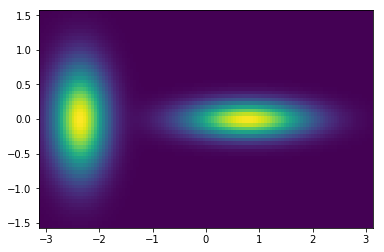

In [5]:
plt.pcolormesh(L_ARRg,B_ARRg,gauss_map)

<h3>Setting up the astropy world coordinate system</h3>

In [6]:
from astropy import wcs
wcs = wcs.WCS(naxis=2)
nx = n_l
ny = n_b
pixscalelon = pixelsize # cdelt1
pixscalelat = pixelsize  # cdelt2


wcs.wcs.crpix = [60+0.5,30+0.5] # Ref pixel for axis 1 and 2
# the 0.5 is important so that the map fits the coordinate grid!!!
wcs.wcs.cdelt = np.array([pixscalelon, pixscalelat]) # what is the pixel scale in lon, lat.
wcs.wcs.crval = [np.rad2deg(l_arrg[60]),np.rad2deg(b_arrg[30])]  #what is the galactic coordinate of that pixel.
wcs.wcs.ctype = ["GLON-CAR", "GLAT-CAR"] #CAR projection #AIT projection

In [7]:
today = datetime.date.today()
today

datetime.date(2023, 4, 3)

<h3>Saving information to file</h3>

In [8]:
header = wcs.to_header()
header['history'] = "Thomas Siegert created this file on "+str(today)+" " 

# define header
hdu = fits.PrimaryHDU(gauss_map,header=header)
    
# save file
hdu.writeto('gauss_map.fits', overwrite=True)

<h3>Conversion from FITS files to MEGAlib dat file (to use with .source in cosima)</h3>

In [9]:
def gal2mega(energy,pixelsize,input_file,output_file):
    from astropy.wcs import WCS

    """
    Convert FITS map to MEGAlib cosima input.

    input_file: fits file to convert to MEGAlib
    energy: line energy (not working for continuum here!)
    output_file: Name of output file (do not include .dat). 
    """

    # Define phi (PA), theta (TA), and energy (EA) points:
    PA = np.arange(l_min,l_max,pixelsize)
    TA = np.arange(0,180+pixelsize/2,pixelsize)
    EA = np.array(energy)

    # Convert PA to file input:
    PA_line = "PA"
    for i in range(0,len(PA)):
        PA_line += " " + str(PA[i])

    # Convert TA to file input:
    TA_line = "TA"
    for i in range(0,len(TA)):
        TA_line += " " + str(TA[i])

    # Convert EA to file input:
    EA_line = "EA"
    for i in range(0,len(EA)):
        EA_line += " " + str(EA[i])

    # Write file:
    f = open(output_file + ".dat","w")
    f.write("IP LIN\n")
    f.write(PA_line + "\n")
    f.write(TA_line + "\n")
    f.write(EA_line + "\n")

    # Make main:
    for E in range(0,len(energy)):

        this_E_list = []
        for i in range(0,len(PA)):

            if PA[i] > 0:
                this_l = PA[i]
            if PA[i] < 0:
                this_l = 360 + PA[i]

            for j in range(0,len(TA)):

                this_b = 90-TA[j]

                # to get flux from mapcube:

                hdu = fits.open(input_file)
                data = hdu[0].data
                #self.energy = hdu[1].data
                #self.energy = self.energy['Energy']
                header = hdu[0].header
                file_wcs = WCS(header)
                
                
                pixs = file_wcs.all_world2pix(np.array([[this_l,this_b]]),0)
                this_l_pix = int(math.floor(pixs[0][0]))
                this_b_pix = int(math.floor(pixs[0][1]))
                this_flux = data[this_b_pix,this_l_pix]# / 1000.0 # ph/cm^2/s/keV/sr

                # Format:
                this_flux = float('{:.5e}'.format(this_flux))

                # Write line:
                this_line = "AP " + str(i) + " " + str(j) + " " + str(E) + " " + str(this_flux) + "\n"
                f.write(this_line)

    # Close file:
    f.write("EN")
    f.close()

In [10]:
gal2mega(energy=[1809.],pixelsize=3,input_file='gauss_map.fits',output_file='gauss_map')

<h3>built-in beta version (with 1 deg pixels fixed, etc)</h3>

In [11]:
from GalMaps import *

/usr/local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [12]:
instance = GalMapsFits()

In [13]:
instance.read_fits_file('gauss_map.fits',energy_list=1.809)


**********************
GALPROP Fits READER



In [14]:
instance.gal2mega("fits",output_file='test2')


energy list [keV]:
[1809.0]

